In [24]:
import keras
import quandl
import numpy as np

from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input

import keras.backend as K
from sklearn.model_selection import KFold

%matplotlib inline

In [2]:
data = quandl.get('BCHARTS/BITFINEXUSD')

In [3]:
data.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2013-03-31,93.250000,100.000000,93.03000,93.100000,390.827224,3.708933e+04,94.899563
2013-04-01,93.170000,105.900000,92.49999,102.370000,4919.654127,4.921010e+05,100.027564
2013-04-02,102.800000,118.388067,99.00000,117.989990,9084.832816,9.874119e+05,108.687953
2013-04-03,116.579097,146.880000,101.51088,134.952969,12909.402178,1.652092e+06,127.975861
2013-04-04,131.779686,143.000000,119.00000,132.681000,6910.100414,9.094385e+05,131.610029


In [4]:
print(data.shape)
#1363,7

mean = data.mean(axis=0)
std = data.std(axis=0)

# normalizando os dados (zscore normalization)
data = ( data - mean ) / std

X = np.zeros((1363,6,7))

#deslocamento
d = 6

#tirando as d primeiras linhas que estao vazias por causa do deslocamento
for i in range(d,data.shape[0]):
    X[i,:,:] = data.iloc[i-d:i].values

#tirando as d primeiras linhas q tao vazias
X = X[d:,:,:]

print(X.shape)

(1363, 7)
(1357, 6, 7)


In [5]:
# criando as labels
Y = data['Weighted Price'] - data.shift(1)['Weighted Price']

Y.shape

(1363,)

In [6]:
Y = Y > 0

#retirando a primeira linha, pois a segunda label refere-se ao primeiro registro (variacao)
Y = Y[1:]

#retirando as d primeiras datas por causa do deslocamento
Y = Y[d:]

In [7]:
#retirando o ultimo registro das features para 
#especificando as outras dimensoes por boas praticas (nao esquecer a matriz)
X = X[: -1,:,:]

In [8]:
# conferindo os chapes
Y.shape, X.shape

((1356,), (1356, 6, 7))

In [9]:
# passando pro formato de 4 dimensoes esperadas
X = X.reshape((1356,6,7,1))

In [28]:
# train / test split
#X_train = X[:-300,:,:,:]
#X_test = X[-300:,:,:,:]
#Y_train = Y[:-300]
#Y_test = Y[-300:]

# trying some cross validation
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

TRAIN: [ 136  137  138 ..., 1353 1354 1355] TEST: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135]
TRAIN: [   0    1    2 ..., 1353 1354 1355] TEST: [136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207
 208 209 210 211 212 213 214 215 216 217 218 219 220 22

In [29]:
def model(input_shape):
    
    X_input = Input(input_shape)
    
    #padding same pra nao reduzir 
    X = Conv2D(10,(3,3), strides=(1,1),name="conv0", padding="same")(X_input)
    X = BatchNormalization(axis=3,name='bn0')(X)
    X = Activation('relu')(X)

    X = MaxPooling2D((2,2),name='max_pool0')(X)
    
    #Second conv
    X = Conv2D(30,(2,2), strides=(1,1),name="conv1", padding="same")(X)
    X = BatchNormalization(axis=3,name='bn1')(X)
    X = Activation('relu')(X)

    X = MaxPooling2D((2,2),name='max_pool1')(X)
    
    #Third conv
    #X = Conv2D(50,(1,1), strides=(1,1),name="conv2", padding="same")(X)
    #X = BatchNormalization(axis=3,name='bn2')(X)
    #X = Activation('relu')(X)
    
    #fcs
    X = Flatten()(X)
    X = Dense(200,activation="relu")(X)
    X = Dense(100,activation="relu")(X)
    X = Dense(50,activation="relu")(X)
    X = Dense(1,activation="sigmoid")(X)
    
    model = Model(inputs=X_input,outputs=X, name="model1")
    
    return model

In [30]:
#instanciando modelo
model = model(X[0].shape)

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=["accuracy"])

model.fit(x = X_train, y = Y_train, epochs = 200, batch_size = 8)

Epoch 1/200
1221/1221 [==============================] - 1s 867us/step - loss: 0.7036 - acc: 0.5037
Epoch 2/200
1221/1221 [==============================] - 1s 610us/step - loss: 0.6938 - acc: 0.5127
Epoch 3/200
1221/1221 [==============================] - 1s 589us/step - loss: 0.6898 - acc: 0.5373
Epoch 4/200
1221/1221 [==============================] - 1s 583us/step - loss: 0.6908 - acc: 0.5397
Epoch 5/200
1221/1221 [==============================] - 1s 646us/step - loss: 0.6909 - acc: 0.5381
Epoch 6/200
1221/1221 [==============================] - 1s 594us/step - loss: 0.6892 - acc: 0.5414
Epoch 7/200
1221/1221 [==============================] - 1s 635us/step - loss: 0.6836 - acc: 0.5602
Epoch 8/200
1221/1221 [==============================] - 1s 593us/step - loss: 0.6882 - acc: 0.5561
Epoch 9/200
1221/1221 [==============================] - 1s 601us/step - loss: 0.6887 - acc: 0.5438
Epoch 10/200
1221/1221 [==============================] - 1s 593us/step - loss: 0.6846 - acc: 0.5717

1221/1221 [==============================] - 1s 489us/step - loss: 0.4772 - acc: 0.7576
Epoch 83/200
1221/1221 [==============================] - 1s 490us/step - loss: 0.4756 - acc: 0.7576
Epoch 84/200
1221/1221 [==============================] - 1s 488us/step - loss: 0.4419 - acc: 0.7641
Epoch 85/200
1221/1221 [==============================] - 1s 490us/step - loss: 0.4707 - acc: 0.7445
Epoch 86/200
1221/1221 [==============================] - 1s 585us/step - loss: 0.4473 - acc: 0.7592
Epoch 87/200
1221/1221 [==============================] - 1s 677us/step - loss: 0.4336 - acc: 0.7682
Epoch 88/200
1221/1221 [==============================] - 1s 737us/step - loss: 0.4294 - acc: 0.7715
Epoch 89/200
1221/1221 [==============================] - 1s 737us/step - loss: 0.4271 - acc: 0.7821
Epoch 90/200
1221/1221 [==============================] - 1s 639us/step - loss: 0.4419 - acc: 0.7535
Epoch 91/200
1221/1221 [==============================] - 1s 523us/step - loss: 0.4328 - acc: 0.7699
Epo

1221/1221 [==============================] - 1s 524us/step - loss: 0.3011 - acc: 0.8411
Epoch 163/200
1221/1221 [==============================] - 1s 494us/step - loss: 0.2919 - acc: 0.8460
Epoch 164/200
1221/1221 [==============================] - 1s 491us/step - loss: 0.2835 - acc: 0.8501 0s - loss: 0.2611 - a
Epoch 165/200
1221/1221 [==============================] - 1s 490us/step - loss: 0.3139 - acc: 0.8419
Epoch 166/200
1221/1221 [==============================] - 1s 501us/step - loss: 0.2645 - acc: 0.8624
Epoch 167/200
1221/1221 [==============================] - 1s 503us/step - loss: 0.2792 - acc: 0.8534
Epoch 168/200
1221/1221 [==============================] - 1s 497us/step - loss: 0.3315 - acc: 0.8346
Epoch 169/200
1221/1221 [==============================] - 1s 495us/step - loss: 0.3242 - acc: 0.8395
Epoch 170/200
1221/1221 [==============================] - 1s 512us/step - loss: 0.2874 - acc: 0.8616
Epoch 171/200
1221/1221 [==============================] - 1s 486us/step -

In [31]:
preds = model.evaluate(x = X_test, y = Y_test)
print()
print("Loss = " + str(preds[0]))
print("Acc = " + str(preds[1]))

135/135 [==============================] - 0s 1ms/step

Loss = 0.894813213083
Acc = 0.52592592725


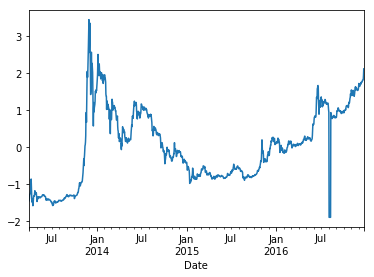

In [14]:
data['Weighted Price'].plot()